In [11]:
import pandas as pd
import numpy as np
import os

In [12]:
df = pd.read_csv('../final_stats/final_season_sent_game_last_3.csv', index_col=[0])
df = df.reset_index(drop=True)
# df

### Drop unused columns
### No sentiment model

Remove all neutral metrics
Remove week, date, home spread, spread from last games. ...............



In [13]:
# always remove
cols_always_remove = [
    'Week',
    'Date',
    'home_spread',
    'away_spread_last_1',
    'home_spread_last_1',
    'away_neutral96',
    'away_neutral24',
    'home_neutral96',
    'home_neutral24',
]

# cols to remove for no sentiment

no_sent_cols_to_remove = [
    'away_positive96',
    'away_positive24',
    'away_negative96',
    'away_negative24',
    'away_sentiment_96h',
    'away_sentiment_24h',
    'away_swing',

    'home_positive96',
    'home_positive24',
    'home_negative96',
    'home_negative24',
    'home_sentiment_96h',
    'home_sentiment_24h', 
    'home_swing',
]

# cols to remove for 96 hour sentiment
sent_96_cols_to_remove = [
    'away_positive24',
    'away_negative24',
    'away_sentiment_24h',
    'away_swing',

    'home_positive24',
    'home_negative24',
    'home_sentiment_24h', 
    'home_swing',
]

# cols to remove for 24 hour sentiment
sent_24_cols_to_remove = [
    'away_positive96',
    'away_negative96',
    'away_sentiment_96h',
    'away_swing',

    'home_positive96',
    'home_negative96',
    'home_sentiment_96h',
    'home_swing',
]

# sentiment to remove for cross
sent_cross_cols_to_remove = [
    'away_positive96',
    'away_positive24',
    'away_negative96',
    'away_negative24',
    'away_sentiment_96h',
    'away_sentiment_24h',

    'home_positive96',
    'home_positive24',
    'home_negative96',
    'home_negative24',
    'home_sentiment_96h',
    'home_sentiment_24h', 
]

In [14]:
df_no_sent = df.drop(cols_always_remove, axis=1)
df_no_sent = df_no_sent.drop(no_sent_cols_to_remove, axis=1)
# df_no_sent['away_spread_last_3']

## one-hot encode teams

In [15]:
def one_hot_encode_teams_days(df):
    df_1hot_home = pd.get_dummies(df.home, prefix='home', drop_first=True)
    df_1hot_away = pd.get_dummies(df.away, prefix='away', drop_first=True)
    df_1hot_days = pd.get_dummies(df.Day, prefix='day', drop_first=True)
    return pd.concat([df_no_sent, df_1hot_home, df_1hot_away,df_1hot_days], axis=1).drop(['home','away', 'Day'], axis=1)

# df_1hot = one_hot_encode_teams_days(df_no_sent)
# df_1hot.head()

In [16]:
def move_away_spread_to_start(df):
    spread_col = df.pop('away_spread')
    df.insert(0, 'away_spread', spread_col)
    return df

# df_1hot1 = move_away_spread_to_start(df_1hot)
# df_1hot1['away_spread'].mean()
# df_1hot1.tail(10)


In [17]:
def find_spread_ties(df):
    df['away_tie'] = df['away_score'] + df['away_spread'] == df['home_score']
    return df.index[df['away_tie']].tolist()


Find one "push" where there is no winner with the spread, teams tied with the spread. 
Game 96 in list. Remove 

In [18]:
def remove_tied_spread_games(df):
    index_to_remove = find_spread_ties(df)
    print('Rows to remove: ', index_to_remove)
    df = df.drop(index_to_remove, axis=0)
    return df

# df_no_ties = remove_tied_spread_games(df_1hot1)


### Create binary target "Away Winner With The Spread (wts)"
Binary Value true or false

In [19]:
def create_winner_with_the_spread_col(df):
    df = df.copy()
    df['away_winner_wts'] = df['away_score'] + df['away_spread'] > df['home_score']
    # convert to 0 1
    df['away_winner_wts'] = df['away_winner_wts'].astype(int)
    col_to_move = df.pop('away_winner_wts')
    df.insert(0, 'away_winner_wts', col_to_move)
    df = df.drop(['home_score','away_score'], axis=1)
    return df

# df11 = convert_actual_spread_to_winner_wts(df_1hot1)

## this is for getting the actual spread rather than a winner with the spread target

In [20]:
def combine_score_to_spread_result(df):
    df = df.copy()
    df['away_actual_spread'] = df['home_score'] - df['away_score']
    col_to_move = df.pop('away_actual_spread')
    df.insert(0, 'away_actual_spread', col_to_move)
    df = df.drop(['home_score','away_score'], axis=1)
    return df

# combine_score_to_spread_result(df_1hot1)

### Combine Previous Preprocessing

In [21]:
def preprocess_1(filepath, cols_to_remove):
    # read csvw
    df = pd.read_csv(filepath, index_col=[0])
    df = df.reset_index(drop=True)
    # drop correct columns
    df = df.drop(cols_always_remove, axis=1)
    df = df.drop(cols_to_remove, axis=1)
    # one-hot encode categorical vars
    df = one_hot_encode_teams_days(df)
    # remove pushed or tied spread games
    df = remove_tied_spread_games(df)
    # move away_spread to first col
    df = move_away_spread_to_start(df)
    # create binary target away winner wts column
    df = create_winner_with_the_spread_col(df)
    return df

    

In [44]:
filepath1 = '../final_stats/final_season_sent_game_last_1.csv'    
filepath3 = '../final_stats/final_season_sent_game_last_3.csv'    
filepath5 = '../final_stats/final_season_sent_game_last_5.csv'    
filepath7 = '../final_stats/final_season_sent_game_last_7.csv'    
filepath10 = '../final_stats/final_season_sent_game_last_10.csv'    

filepaths = [
    ['last_1', filepath1 ],
    ['last_3', filepath3],
    ['last_5', filepath5],
    ['last_7', filepath7],
    ['last_10', filepath10]
]

columns = [
    ['no_sent', no_sent_cols_to_remove],
    ['sent_96', sent_96_cols_to_remove],
    ['sent_24', sent_24_cols_to_remove],
    ['sent_cross', sent_cross_cols_to_remove]
]

def save_all_datasets(filepaths, columns):
    for x in filepaths:
        key_file = x[0]
        filepath = x[1]
        for y in columns:
            key_col = y[0]
            cols = y[1]
            df = preprocess_1(filepath, cols)
            save_file_name = f'preprocessed_{key_col}_{key_file}.csv'
            df.to_csv(f'../final_stats/preprocessed/{save_file_name}')
        


df_1 = preprocess_1(filepath1, no_sent_cols_to_remove)
# df1_no_sent = preprocess_1(filepath3, no_sent_cols_to_remove)
# df1_no_sent = preprocess_1(filepath3, no_sent_cols_to_remove)
# df1_no_sent = preprocess_1(filepath3, no_sent_cols_to_remove)


Rows to remove:  [96]


In [45]:
df_1

,away_winner_wts,away_spread,home_score_team_last_1,home_score_opp_last_1,home_pass_cmp_off_last_1,home_pass_att_off_last_1,home_pass_yds_off_last_1,home_pass_tds_off_last_1,home_ints_off_last_1,home_sacks_off_last_1,...,away_saints,away_seahawks,away_steelers,away_texans,away_titans,away_vikings,day_Sat,day_Sun,day_Thu,away_tie
0,1,-1.5,27.0,17.0,24.0,29.0,320.0,3.0,1.0,3.0,...,0,0,0,0,0,0,0,1,0,False
1,0,-3.0,23.0,31.0,28.0,41.0,316.0,3.0,0.0,1.0,...,0,0,0,0,0,0,0,1,0,False
2,0,14.0,39.0,17.0,26.0,33.0,296.0,3.0,0.0,1.0,...,0,0,0,1,0,0,0,1,0,False
3,0,4.0,23.0,10.0,15.0,27.0,191.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,False
4,0,-1.0,3.0,13.0,21.0,33.0,169.0,0.0,2.0,4.0,...,0,0,0,0,0,0,0,1,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,0,-2.5,20.0,16.0,20.0,32.0,203.0,1.0,0.0,1.0,...,0,0,0,0,0,0,1,0,0,False
102,1,13.5,35.0,23.0,19.0,31.0,237.0,3.0,1.0,2.0,...,0,0,0,0,0,0,0,1,0,False
103,1,3.0,29.0,13.0,28.0,33.0,341.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,1,0,False
104,1,8.5,27.0,16.0,25.0,42.0,202.0,1.0,0.0,2.0,...,0,0,0,0,0,0,0,1,0,False


## Predict the away actual spread

In [46]:
def split_target(df, target_col='away_winner_wts'):
    df = df.copy()
    target = df.pop(target_col)
    return df, target

Balanced dataset, 53 home winners wts and 52 away winners with the spread


## Normailze all columns


In [47]:
from sklearn.preprocessing import MinMaxScaler

def normalize_df(df):
    scaler = MinMaxScaler()
    df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    data, target = split_target(df)
    return data, target

data,target = normalize_df(df_1)


In [48]:
target

0      1.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
100    0.0
101    1.0
102    1.0
103    1.0
104    1.0
Name: away_winner_wts, Length: 105, dtype: float64

In [49]:
import tensorflow as tf

In [50]:
# normalizer = tf.keras.layers.Normalization(axis=-1)

def get_basic_model():
    model = tf.keras.Sequential([
        # normalizer,
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['accuracy'])
    
    return model
    

In [51]:
model = get_basic_model()
history = model.fit(data, target, epochs=50, validation_split=0.2)

Epoch 1/50
3/3 [==============================] - 1s 93ms/step - loss: 7.3452 - accuracy: 0.5238 - val_loss: 8.8143 - val_accuracy: 0.4286
Epoch 2/50
3/3 [==============================] - 0s 16ms/step - loss: 7.3452 - accuracy: 0.5238 - val_loss: 8.8143 - val_accuracy: 0.4286
Epoch 3/50
3/3 [==============================] - 0s 17ms/step - loss: 7.3452 - accuracy: 0.5238 - val_loss: 8.8143 - val_accuracy: 0.4286
Epoch 4/50
3/3 [==============================] - 0s 16ms/step - loss: 7.3452 - accuracy: 0.5238 - val_loss: 8.8143 - val_accuracy: 0.4286
Epoch 5/50
3/3 [==============================] - 0s 16ms/step - loss: 7.3452 - accuracy: 0.5238 - val_loss: 8.8143 - val_accuracy: 0.4286
Epoch 6/50
3/3 [==============================] - 0s 16ms/step - loss: 7.3452 - accuracy: 0.5238 - val_loss: 8.8143 - val_accuracy: 0.4286
Epoch 7/50
3/3 [==============================] - 0s 17ms/step - loss: 7.3452 - accuracy: 0.5238 - val_loss: 8.8143 - val_accuracy: 0.4286
Epoch 8/50
3/3 [===========

In [31]:
import matplotlib.pyplot as plt

def plot_train_val_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    blue_dots = 'bo'
    solid_blue_line = 'b'

    plt.plot(epochs, loss, blue_dots, label = 'Training loss')
    plt.plot(epochs, val_loss, solid_blue_line, label = 'Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
    
def plot_train_val_acc(history):
    plt.clf()

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
        
    epochs = range(1, len(acc) + 1)

    blue_dots = 'bo'
    solid_blue_line = 'b'
        
    plt.plot(epochs, acc, blue_dots, label = 'Training Accuracy')
    plt.plot(epochs, val_acc, solid_blue_line, label = 'Validation Accuracy')
    plt.title('Training and validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

def plot_train_val_loss_acc(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(1, len(acc) + 1)
    blue_dots = 'bo'
    solid_blue_line = 'b'

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    # plt.plot(epochs_range, acc, label='Training Accuracy')
    # plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    
 
    plt.plot(epochs_range, acc, blue_dots, label = 'Training Accuracy')
    plt.plot(epochs_range, val_acc, solid_blue_line, label = 'Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, blue_dots, label='Training Loss')
    plt.plot(epochs_range, val_loss, solid_blue_line, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
  
def compare_loss(hist1, hist2, title1, title2): 
    min_epochs = min(len(hist1.history['loss']), len(hist2.history['loss']))
    loss = hist1.history['loss'][:min_epochs]
    val_loss = hist1.history['val_loss'][:min_epochs]
    loss_drop = hist2.history['loss'][:min_epochs]
    val_loss_drop = hist2.history['val_loss'][:min_epochs]

    epochs = range(1, min_epochs + 1)

    blue_dots = 'bo'
    solid_blue_line = 'b'
    red_dots = 'ro'
    solid_red_line = 'r'

    plt.plot(epochs, loss, blue_dots, label = f'{title1} Training Loss')
    plt.plot(epochs, val_loss, solid_blue_line, label = f'{title1} Validation Loss')
    plt.plot(epochs, loss_drop, red_dots, label = f'{title2} Training Loss')
    plt.plot(epochs, val_loss_drop, solid_red_line, label = f'{title2} Validation Loss')
    # plt.title('Loss With Dropout Layers')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

def compare_acc(hist1, hist2, title1, title2): 
    min_epochs = min(len(hist1.history['accuracy']), len(hist2.history['accuracy']))
    acc = hist1.history['accuracy'][:min_epochs]
    val_acc = hist1.history['val_accuracy'][:min_epochs]
    acc_drop = hist2.history['accuracy'][:min_epochs]
    val_acc_drop = hist2.history['val_accuracy'][:min_epochs]
    
    epochs = range(1, min_epochs + 1)

    blue_dots = 'bo'
    solid_blue_line = 'b'
    red_dots = 'ro'
    solid_red_line = 'r'

    plt.plot(epochs, acc, blue_dots, label = f'{title1} Training Accuracy')
    plt.plot(epochs, val_acc, solid_blue_line, label = f'{title1} Validation Accuracy')
    plt.plot(epochs, acc_drop, red_dots, label = f'{title2} Training Accuracy')
    plt.plot(epochs, val_acc_drop, solid_red_line, label = f'{title2} Validation Accuracy')
    # plt.title('Accuracy With Dropout Layers')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

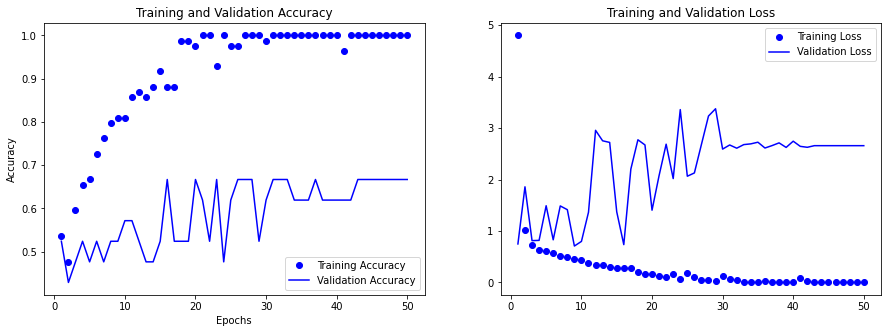

In [32]:
plot_train_val_loss_acc(history)